In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# importing libraries
import tensorflow as tf
import keras
import os
import io
import glob
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.utils import plot_model
from skimage.restoration import denoise_wavelet
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score,precision_score, recall_score, f1_score

In [4]:
# Importing Resized Fundus and OCT images (fundus images resized to 224x224 and OCT to 467 x 224)
Fundus_Normal = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Normal/*.jpg")
print(Fundus_Normal)
Fundus_Mild = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Mild/*.jpg")
print(Fundus_Mild)
Fundus_Moderate = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Moderate/*.jpg")
print(Fundus_Moderate)
Fundus_Severe = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Severe/*.jpg")
print(Fundus_Severe)
OCT_Glaucoma = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/OCT/Glaucoma/*.jpg")
print(OCT_Glaucoma)
OCT_Non_Glaucoma = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/OCT/Non_Glaucoma/*.jpg")
print(OCT_Non_Glaucoma)

['/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Normal/P7_R_Norm.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Normal/P4_R_Norm.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Normal/P9_R_Norm.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Normal/P15_L_Norm.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Normal/P14_R_Norm.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Normal/P7_L_Norm.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Normal/P15_R_Norm.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Normal/P3_R_Norm.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Normal/P11_R_Norm.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Normal/P9_L_Norm.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Normal/P11_L_Norm.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Normal/P2_L_Norm.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Fundus/Normal/P25_L_Norm.jpg', '/content/drive/My

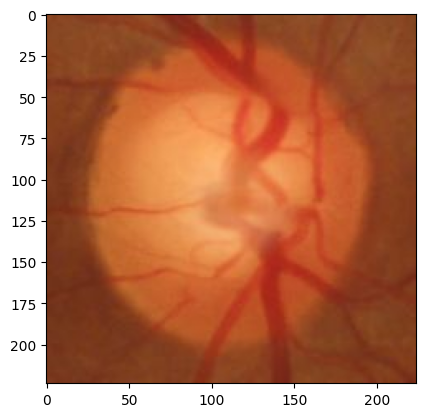

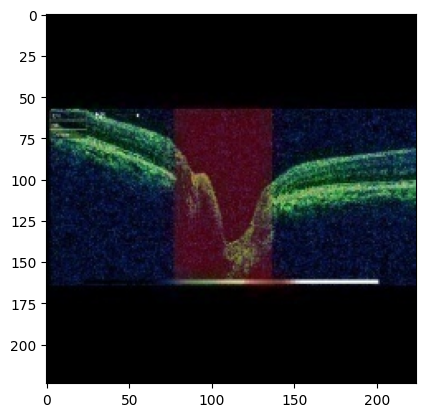

In [5]:
# accessing the image files from the split dataset
image1 = io.imread(Fundus_Moderate[12])
image2 = io.imread(OCT_Non_Glaucoma[5])
i, (im1) = plt.subplots(1)
i, (im2) = plt.subplots(1)
i.set_figwidth(5)
im1.imshow(image1)
im2.imshow(image2)

In [6]:
# Resize OCT images to 224 x 224

def resize_images(images, target_size):
    resized_images = []
    for img_path in images:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue
        # Calculate the aspect ratio of the original image
        img_height, img_width = img.shape[:2]
        aspect_ratio = img_width / img_height

        # Resize the image while preserving the aspect ratio
        if aspect_ratio > 1:
            new_width = target_size
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = target_size
            new_width = int(new_height * aspect_ratio)

        # Resize the image using OpenCV
        resized_img = cv2.resize(img, (new_width, new_height))

        # Pad the image if needed to match the target size
        pad_top = (target_size - new_height) // 2
        pad_bottom = target_size - new_height - pad_top
        pad_left = (target_size - new_width) // 2
        pad_right = target_size - new_width - pad_left
        padded_img = cv2.copyMakeBorder(resized_img, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT)

        # Save the resized image back to the original file location
        output_path = img_path  # Save back to the same file
        cv2.imwrite(output_path, padded_img)

        resized_images.append(output_path)

    return resized_images

# Define the target size for resizing
target_size = 224

# Resize OCT_Glaucoma images
OCT_Glaucoma_resized = resize_images(OCT_Glaucoma, target_size)

# Resize OCT_Non_Glaucoma images
OCT_Non_Glaucoma_resized = resize_images(OCT_Non_Glaucoma, target_size)

# Replace the original lists with the resized images
OCT_Glaucoma = OCT_Glaucoma_resized
OCT_Non_Glaucoma = OCT_Non_Glaucoma_resized


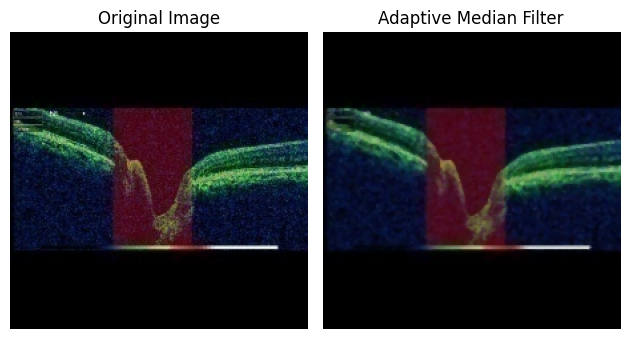

In [7]:
# Applying the Median Blur
filtered_image = cv2.medianBlur(image2, 3)  #Filter the image
# Display the images
f, (plot1, plot2) = plt.subplots(1, 2)
plot1.imshow(image2)
plot1.set_title('Original Image')
plot1.axis('off')

plot2.imshow(filtered_image)
plot2.set_title('Adaptive Median Filter')
plot2.axis('off')

plt.tight_layout()
plt.show()

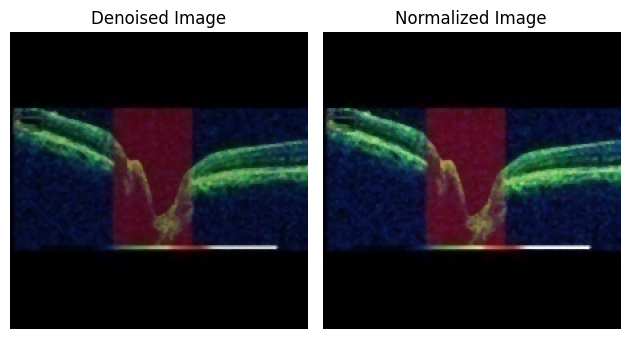

In [8]:
# Wavelet Denoising, Normalization & Normalizing Input Channels
denoised_image = denoise_wavelet(filtered_image)
normalized_image = (denoised_image - np.min(denoised_image)) / (np.max(denoised_image) - np.min(denoised_image))
normalized_image = np.clip(normalized_image, 0, 1)  # Clip values to [0, 1] range

# Scale the pixel values to the range [0, 255]
scaled_image = (normalized_image * 255).astype(np.uint8)

# Display the images
f, (plot1, plot2) = plt.subplots(1, 2)
plot1.imshow(denoised_image)
plot1.set_title('Denoised Image')
plot1.axis('off')

plot2.imshow(normalized_image,)
plot2.set_title('Normalized Image')
plot2.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Applying the filter to fundus and OCT images
# Adaptive Median Filter
def adaptive_median_filter(image, kernel_size=3):
    filtered_image = cv2.medianBlur(image, kernel_size)
    return filtered_image

# Wavelet Denoising
def wavelet_denoising(image):
    denoised_image = denoise_wavelet(image)
    return denoised_image

# Normalization
def normalize_image(image):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return normalized_image

# Normalizing Input Channels
def normalize_channels(image):
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return normalized_image

def process_images(image_paths, output_dir, is_glaucoma=False, is_severity=False):
    for image_path in image_paths:
        image = cv2.imread(image_path)
        #grayscale_image = convert_to_grayscale(image)
        filtered_image = adaptive_median_filter(image)
        denoised_image = wavelet_denoising(filtered_image)
        normalized_image = normalize_image(denoised_image)
        normalized_channels_image = normalize_channels(normalized_image)

        # Extract the file name and extension
        filename = os.path.splitext(os.path.basename(image_path))[0]

        # Define the output file path
        output_file = os.path.join(output_dir, f"{filename}_processed.jpg")

        # Save the processed image as a JPEG file
        cv2.imwrite(output_file, normalized_channels_image)


# Output folders
output_dir_severity_normal = "/content/drive/MyDrive/Colab Notebooks/Data/ProcessedImages/Fundus_Normal"
output_dir_severity_mild = "/content/drive/MyDrive/Colab Notebooks/Data/ProcessedImages/Fundus_Mild"
output_dir_severity_moderate = "/content/drive/MyDrive/Colab Notebooks/Data/ProcessedImages/Fundus_Moderate"
output_dir_severity_severe = "/content/drive/MyDrive/Colab Notebooks/Data/ProcessedImages/Fundus_Severe"

output_dir_glaucoma_oct = "/content/drive/MyDrive/Colab Notebooks/Data/ProcessedImages/OCT_Glaucoma"
output_dir_non_glaucoma_oct = "/content/drive/MyDrive/Colab Notebooks/Data/ProcessedImages/OCT_Non_Glaucoma"

# Process the Fundus images
process_images(Fundus_Normal, output_dir=output_dir_severity_normal, is_severity=False,)
process_images(Fundus_Mild, output_dir=output_dir_severity_mild, is_severity=True, )
process_images(Fundus_Moderate, output_dir=output_dir_severity_moderate, is_severity=True,)
process_images(Fundus_Severe, output_dir=output_dir_severity_severe, is_severity=True,)


# Process the OCT images
process_images(OCT_Glaucoma,output_dir=output_dir_glaucoma_oct,is_glaucoma=True)
process_images(OCT_Non_Glaucoma, output_dir=output_dir_non_glaucoma_oct,is_glaucoma=False,)

In [10]:
# Importing Filtered Images
Processed_Fundus_Normal = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/ProcessedImages/Fundus_Normal/*.jpg")
print(len(Processed_Fundus_Normal))
Processed_Fundus_Mild = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/ProcessedImages/Fundus_Mild/*.jpg")
print(len(Processed_Fundus_Mild))
Processed_Fundus_Moderate = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/ProcessedImages/Fundus_Moderate/*.jpg")
print(len(Processed_Fundus_Moderate))
Processed_Fundus_Severe = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/ProcessedImages/Fundus_Severe/*.jpg")
print(len(Processed_Fundus_Severe))
Processed_OCT_Glaucoma = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/ProcessedImages/OCT_Glaucoma/*.jpg")
print(len(Processed_OCT_Glaucoma))
Processed_OCT_Non_Glaucoma = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/ProcessedImages/OCT_Non_Glaucoma/*.jpg")
print(len(Processed_OCT_Non_Glaucoma))

18
9
14
7
30
18


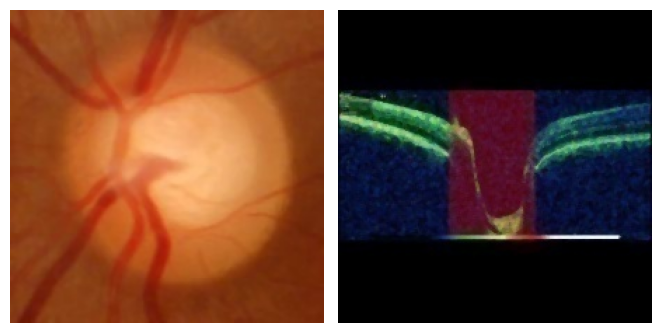

In [11]:
# Display the images
plt.figure(figsize=(10, 6))
processed1 = io.imread(Processed_Fundus_Severe[5])
processed2 = io.imread(Processed_OCT_Glaucoma[15])

# Display the fundus image
plt.subplot(131)
plt.imshow(processed1)
plt.axis("off")

# Display the OCT image
plt.subplot(132)
plt.imshow(processed2, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()

In [12]:
# Create 100 augmentations for OCT & Fundus images
#Initialize lists to store the selected images
image_list_rot = []
image_list_width = []
image_list_height = []
image_list_horizon = []
image_list_vert = []
image_list_shear = []
image_list_zoom = []
image_list_bright = []
image_list_channel = []

desired_num_augmented_images = 100

# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator (
rescale=1./255,                      # Normalize pixel values to [0, 1]
rotation_range=20,                   # Randomly rotate images within the range of (-20, 20) degrees
width_shift_range=0.2,               # Randomly shift images horizontally (fraction of total width)
height_shift_range=0.2,              # Randomly shift images vertically (fraction of total height)
horizontal_flip=True,                # Randomly flip images horizontally
vertical_flip=True,                  # Randomly flip images vertically
shear_range=0.2,                     # Apply shear transformations with a range of (-0.2, 0.2)
brightness_range=[0.8, 1.2],         # Randomly adjust brightness within the range of (0.8, 1.2)
channel_shift_range=20,              # Randomly shift channel values within the range of (-20, 20)
fill_mode='nearest'                  # Use nearest mode for filling newly created pixels
)

# Define a function to augment and save images
def augment_and_save_images(images, output_folder):
    num_images = len(images)
    num_augmentations = desired_num_augmented_images // num_images

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    for image_path in images:
        image_name = os.path.basename(image_path)
        image = cv2.imread(image_path)
        # Augment the image and save
        for i in range(num_augmentations):
            augmented_image = datagen.random_transform(image)

            # Check if the augmentation parameters match criteria
            if datagen.rotation_range == 20:
              image_list_rot.append(augmented_image)

            if datagen.width_shift_range == 0.2:
              image_list_width.append(augmented_image)

            if datagen.height_shift_range == 0.2:
              image_list_height.append(augmented_image)

            if datagen.horizontal_flip:
              image_list_horizon.append(augmented_image)

            if datagen.vertical_flip:
              image_list_vert.append(augmented_image)

            if datagen.shear_range == 0.2:
              image_list_shear.append(augmented_image)

            if datagen.zoom_range == 0.2 :
              image_list_zoom.append(augmented_image)

            if datagen.brightness_range == [0.8, 1.2]:
              image_list_bright.append(augmented_image)

            if datagen.channel_shift_range == 20:
              image_list_channel.append(augmented_image)

            augmented_image_path = os.path.join(output_folder, f"{image_name.split('.')[0]}_{i}.jpg")
            cv2.imwrite(augmented_image_path, augmented_image)

# Output folders for augmented images
output_folder_glaucoma_oct = "/content/drive/MyDrive/Colab Notebooks/Data/Augmented/OCT_Glaucoma"
output_folder_non_glaucoma_oct = "/content/drive/MyDrive/Colab Notebooks/Data/Augmented/OCT_Non_Glaucoma"
output_folder_severity_normal = "/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Normal"
output_folder_severity_mild = "/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Mild"
output_folder_severity_moderate = "/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Moderate"
output_folder_severity_severe = "/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Severe"

# Augment and save images for OCT Images
augment_and_save_images(Processed_OCT_Glaucoma, output_folder_glaucoma_oct)
augment_and_save_images(Processed_OCT_Non_Glaucoma, output_folder_non_glaucoma_oct)

# Augment and save images for Fundus Images
augment_and_save_images(Processed_Fundus_Normal, output_folder_severity_normal)
augment_and_save_images(Processed_Fundus_Mild, output_folder_severity_mild)
augment_and_save_images(Processed_Fundus_Moderate, output_folder_severity_moderate)
augment_and_save_images(Processed_Fundus_Severe, output_folder_severity_severe)

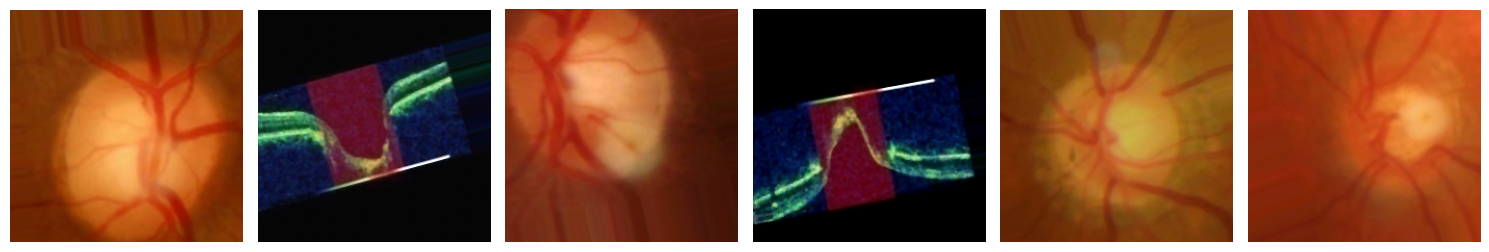

In [13]:
# Display images from Augmented Lists

num_images = len(image_list_channel)
num_plots = min(num_images, 6)  # Maximum number of plots is 6 or the total number of images, whichever is smaller

# Randomly select num_plots number of images
selected_images = random.sample(image_list_rot, num_plots)

# Create subplots to show the images
fig, axes = plt.subplots(1, num_plots, figsize=(15, 3))

# Iterate over the selected images and plot them
for i, image in enumerate(selected_images):
    ax = axes[i]
    # Convert image to RGB color space if needed and swap channels
    if len(image.shape) == 2:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[2] == 1:  # Single-channel image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[2] == 4:  # RGBA image
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    elif image.shape[2] == 3:  # BGR image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Rescale image values to [0, 1]
    image = image.astype(np.float32) / 255.0

    ax.imshow(image)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Importing Augmented Images
Aug_Fundus_Normal = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Normal/*.jpg")
print(Aug_Fundus_Normal)
print(len(Aug_Fundus_Normal))
Aug_Fundus_Mild = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Mild/*.jpg")
print(Aug_Fundus_Mild)
print(len(Aug_Fundus_Mild))
Aug_Fundus_Moderate = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Moderate/*.jpg")
print(Aug_Fundus_Moderate)
print(len(Aug_Fundus_Moderate))
Aug_Fundus_Severe = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Severe/*.jpg")
print(Aug_Fundus_Severe)
print(len(Aug_Fundus_Severe))
Aug_OCT_Glaucoma = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/Augmented/OCT_Glaucoma/*.jpg")
print(Aug_OCT_Glaucoma)
print(len(Aug_OCT_Glaucoma))
Aug_OCT_Non_Glaucoma = glob.glob("/content/drive/MyDrive/Colab Notebooks/Data/Augmented/OCT_Non_Glaucoma/*.jpg")
print(Aug_OCT_Non_Glaucoma)
print(len(Aug_OCT_Non_Glaucoma))

['/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Normal/P4_R_Norm_processed_2.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Normal/P4_R_Norm_processed_1.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Normal/P4_R_Norm_processed_3.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Normal/P7_L_Norm_processed_0.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Normal/P4_R_Norm_processed_4.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Normal/P7_L_Norm_processed_1.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Normal/P7_L_Norm_processed_3.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Normal/P7_L_Norm_processed_2.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Normal/P14_R_Norm_processed_0.jpg', '/content/drive/MyDrive/Colab Notebooks/Data/Augmented/Fundus_Normal/P7_L_Norm_processed_4.jpg', '/content/drive/MyDrive/Cola

In [15]:
# Remove items from augmented lists to create 100 samples for fundus images and 200 for OCT images

# Remove 8 random items from Aug_Fundus_Normal
num_items_to_remove = 8
items_to_remove_fundus = random.sample(Aug_Fundus_Normal, num_items_to_remove)
Aug_Fundus_Normal = [item for item in Aug_Fundus_Normal if item not in items_to_remove_fundus]
Aug_Fundus_Normal = Aug_Fundus_Normal
print(len(Aug_Fundus_Normal))

# Remove 8 random items from Aug_Fundus_Mild
items_to_remove_fundus1 = random.sample(Aug_Fundus_Mild, num_items_to_remove)
Aug_Fundus_Mild = [item for item in Aug_Fundus_Mild if item not in items_to_remove_fundus1]
Aug_Fundus_Mild = Aug_Fundus_Mild
print(len(Aug_Fundus_Mild))

# Remove 12 random items from Aug_Fundus_Moderate
num_items_to_remove1 = 12
items_to_remove_fundus2 = random.sample(Aug_Fundus_Moderate, num_items_to_remove1)
Aug_Fundus_Moderate= [item for item in Aug_Fundus_Moderate if item not in items_to_remove_fundus2]
Aug_Fundus_Moderate = Aug_Fundus_Moderate
print(len(Aug_Fundus_Moderate))

# Remove 5 random items from Aug_Fundus_Severe
num_items_to_remove2 = 5
items_to_remove_fundus3 = random.sample(Aug_Fundus_Severe, num_items_to_remove2)
Aug_Fundus_Severe = [item for item in Aug_Fundus_Severe if item not in items_to_remove_fundus3]
Aug_Fundus_Severe = Aug_Fundus_Severe
print(len(Aug_Fundus_Severe))

# Remove 20 random items from Aug_OCT_Glaucoma
num_items_to_remove3 = 20
items_to_remove_oct = random.sample(Aug_OCT_Glaucoma, num_items_to_remove3)
Aug_OCT_Glaucoma = [item for item in Aug_OCT_Glaucoma if item not in items_to_remove_oct]
Aug_OCT_Glaucoma = Aug_OCT_Glaucoma
print(len(Aug_OCT_Glaucoma))

# Remove 8 random items from Aug_OCT_Non_Glaucoma
num_items_to_remove4 = 8
items_to_remove_oct1 = random.sample(Aug_OCT_Non_Glaucoma, num_items_to_remove4)
Aug_OCT_Non_Glaucoma = [item for item in Aug_OCT_Non_Glaucoma if item not in items_to_remove_oct1]
Aug_OCT_Non_Glaucoma = Aug_OCT_Non_Glaucoma
print(len(Aug_OCT_Non_Glaucoma))



82
91
86
93
70
82


In [16]:
# Join the processed list with augmented list
Fundus_NORM = Processed_Fundus_Normal + Aug_Fundus_Normal
print (len(Fundus_NORM))
Fundus_MILD = Processed_Fundus_Mild + Aug_Fundus_Mild
print (len(Fundus_MILD))
Fundus_MOD = Processed_Fundus_Moderate + Aug_Fundus_Moderate
print (len(Fundus_MOD))
Fundus_SEV = Processed_Fundus_Severe + Aug_Fundus_Severe
print (len(Fundus_SEV))
OCT_G = Processed_OCT_Glaucoma + Aug_OCT_Glaucoma
print (len(OCT_G))
OCT_NG= Processed_OCT_Non_Glaucoma + Aug_OCT_Non_Glaucoma
print (len(OCT_NG))

100
100
100
100
100
100


In [17]:
# Splitting the OCT Image sets into train, test and validation sets

# OCT images labels
OCT_glaucoma_images = OCT_G   # List of OCT glaucoma images
OCT_non_glaucoma_images = OCT_NG    # List of OCT non- glaucoma images

# Shuffle the images and labels together
random.seed(42)  # Set a seed for reproducibility
random.shuffle(OCT_glaucoma_images)
random.shuffle(OCT_non_glaucoma_images)

# Define split ratios
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

# Calculate the number of images for each set
num_glaucoma = len(OCT_glaucoma_images)
num_non_glaucoma = len(OCT_non_glaucoma_images)

num_train_glaucoma = int(train_ratio * num_glaucoma)
num_test_glaucoma = int(test_ratio * num_glaucoma)
num_val_glaucoma = num_glaucoma - num_train_glaucoma - num_test_glaucoma

num_train_non_glaucoma = int(train_ratio * num_non_glaucoma)
num_test_non_glaucoma = int(test_ratio * num_non_glaucoma)
num_val_non_glaucoma = num_non_glaucoma - num_train_non_glaucoma - num_test_non_glaucoma

# Split glaucoma images into train, test, and validation sets
train_glaucoma = OCT_glaucoma_images[:num_train_glaucoma]
test_glaucoma = OCT_glaucoma_images[num_train_glaucoma:num_train_glaucoma+num_test_glaucoma]
val_glaucoma = OCT_glaucoma_images[num_train_glaucoma+num_test_glaucoma:num_train_glaucoma+num_test_glaucoma+num_val_glaucoma]

# Split non-glaucoma images into train, test, and validation sets
train_non_glaucoma = OCT_non_glaucoma_images[:num_train_non_glaucoma]
test_non_glaucoma = OCT_non_glaucoma_images[num_train_non_glaucoma:num_train_non_glaucoma+num_test_non_glaucoma]
val_non_glaucoma = OCT_non_glaucoma_images[num_train_non_glaucoma+num_test_non_glaucoma:num_train_non_glaucoma+num_test_non_glaucoma+num_val_non_glaucoma]

# Combine glaucoma and non-glaucoma sets for each split
train_set = train_glaucoma + train_non_glaucoma
test_set = test_glaucoma + test_non_glaucoma
val_set = val_glaucoma + val_non_glaucoma

# Create labels for each set
train_labels = [1] * num_train_glaucoma + [0] * num_train_non_glaucoma
test_labels = [1] * num_test_glaucoma + [0] * num_test_non_glaucoma
val_labels = [1] * num_val_glaucoma + [0] * num_val_non_glaucoma

# Verify the lengths of the sets and labels
print(len(train_set), len(train_labels))
print(len(test_set), len(test_labels))
print(len(val_set), len(val_labels))


140 140
30 30
30 30


In [18]:
# CNN1 Model for Prediction of Glaucoma from OCT Images
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2

def create_cnn1():
    # Load VGG16 model without the fully connected layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the convolutional layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Create a new model and add VGGNet as the base
    model = Sequential()
    model.add(base_model)

    # Add batch normalization layer
    model.add(BatchNormalization())

    # Flatten the output from the base model
    model.add(Flatten())

    # Add dropout layer
    model.add(Dropout(0.6))


    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.4)))
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.4)))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.3)))
    model.add(Dropout(0.5))

    # Add the output layer for binary classification (glaucoma or not)
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

def load_images(image_paths):
      images = []
      for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to load image: {image_path}")
            continue
          # Convert BGR to RGB format
        images.append(img)
      return np.array(images)

def preprocess_set(images):
    preprocessed_set = []
    for img in images:
        # Preprocess the image (normalize, convert to BGR, etc.)
        preprocessed_img = preprocess_input(img)
        preprocessed_set.append(preprocessed_img)
    return np.array(preprocessed_set)

# Create CNN1 model
cnn1 = create_cnn1()

# Pre-defined train, test, and validation sets
train_set_images = load_images(train_set)
train_set_preprocessed = preprocess_set(train_set_images)

val_set_images = load_images(val_set)
val_set_preprocessed = preprocess_set(val_set_images)

test_set_images = load_images(test_set)
test_set_preprocessed = preprocess_set(test_set_images)

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

# Train the model on the training set
cnn1.fit(train_set_preprocessed, train_labels, epochs=12, batch_size=16, verbose=1)

# Evaluate the model on the validation set
validation_loss, validation_accuracy = cnn1.evaluate(val_set_preprocessed, val_labels, verbose=0)
print(f"Validation accuracy: {validation_accuracy}")

# Evaluate the model on the test set
test_loss, test_accuracy = cnn1.evaluate(test_set_preprocessed, test_labels, verbose=0)
print(f"Test accuracy: {test_accuracy}")


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/12
9/9 [==============================] - 91s 10s/step - loss: 397.0777 - accuracy: 0.5286
Epoch 2/12
9/9 [==============================] - 89s 10s/step - loss: 188.3520 - accuracy: 0.5643
Epoch 3/12
9/9 [==============================] - 89s 10s/step - loss: 140.0913 - accuracy: 0.5643
Epoch 4/12
9/9 [==============================] - 94s 10s/step - loss: 106.1194 - accuracy: 0.7071
Epoch 5/12
9/9 [==============================] - 90s 10s/step - loss: 77.2822 - accuracy: 0.8429
Epoch 6/12
9/9 [==============================] - 90s 10s/step - loss: 56.8973 - accuracy: 0.7929
Epoch 7/12
9/9 [==============================] - 89s 10s/step - loss: 41.7339 - accuracy: 0.8786
Epoch 8/12
9/9 [==============================] - 88s 10s/step - loss: 30.8511 - accuracy: 0.9071
Epoch 9/12
9/9 [==============================] - 89s 10s/step - loss: 22.7387 - accuracy: 0.9571
Epoch 10/12
9/9 [==============================] 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

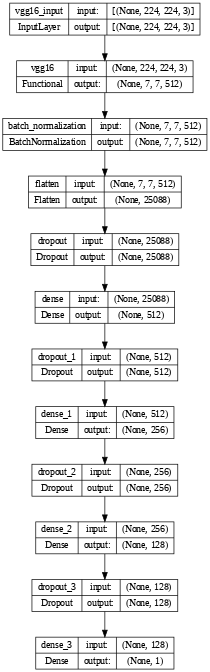

In [19]:
# Architecture for CNN1

# Print the model summary
cnn1.summary()
# Save the model architecture diagram to a file
plot_model(cnn1, to_file='model_architecture.png', show_shapes=True, dpi=50)


Epoch 1/12
9/9 [==============================] - 110s 12s/step - loss: 7.7076 - accuracy: 0.9714 - val_loss: 7.0744 - val_accuracy: 0.8333
Epoch 2/12
9/9 [==============================] - 109s 12s/step - loss: 6.0900 - accuracy: 0.9429 - val_loss: 5.6392 - val_accuracy: 0.7667
Epoch 3/12
9/9 [==============================] - 109s 13s/step - loss: 5.0191 - accuracy: 0.8929 - val_loss: 4.8655 - val_accuracy: 0.7667
Epoch 4/12
9/9 [==============================] - 110s 12s/step - loss: 4.3506 - accuracy: 0.8929 - val_loss: 4.2082 - val_accuracy: 0.7000
Epoch 5/12
9/9 [==============================] - 110s 12s/step - loss: 3.6859 - accuracy: 0.9286 - val_loss: 3.6858 - val_accuracy: 0.6000
Epoch 6/12
9/9 [==============================] - 109s 12s/step - loss: 3.2194 - accuracy: 0.8786 - val_loss: 3.1984 - val_accuracy: 0.7333
Epoch 7/12
9/9 [==============================] - 109s 13s/step - loss: 2.7215 - accuracy: 0.9429 - val_loss: 2.7452 - val_accuracy: 0.7333
Epoch 8/12
9/9 [====

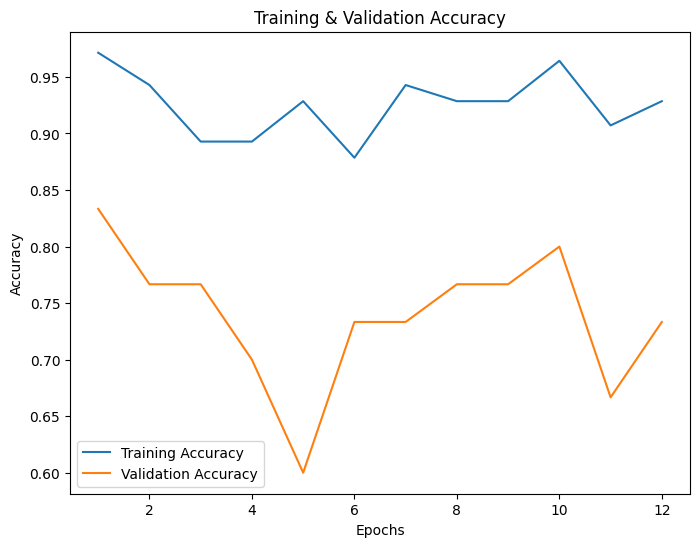

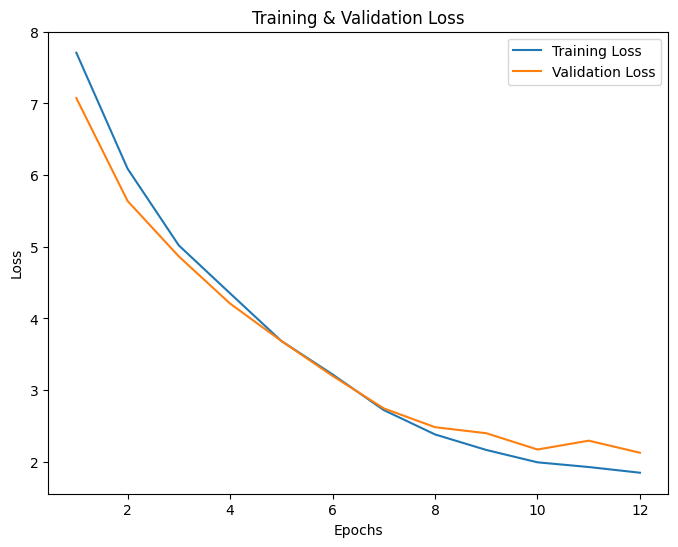

In [20]:
# Creating plots for model accuracy and model loss

# Access the training history
history = cnn1.fit(
    train_set_preprocessed, train_labels,
    epochs=12, batch_size=16,
    verbose=1,
    validation_data=(val_set_preprocessed, val_labels)  # Include validation data
)

# Extract the training loss and accuracy values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a range of epochs based on the length of the training history
epochs = range(1, len(train_loss) + 1)

# Create a figure for model accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

# Create a figure for model loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()



In [21]:
# Metrics for CNN1

# Predict labels for validation set
y_val_pred = cnn1.predict(val_set_preprocessed)
# Convert probabilities to binary labels (0 or 1)
y_val_pred = (y_val_pred > 0.5).astype(int)

# Predict labels for test set
y_test_pred = cnn1.predict(test_set_preprocessed)
# Convert probabilities to binary labels (0 or 1)
y_test_pred = (y_test_pred > 0.5).astype(int)

y_val_true = val_labels
y_test_true = test_labels

# Calculate the validation metrics
val_accuracy = accuracy_score(y_val_true, y_val_pred)
val_precision = precision_score(y_val_true, y_val_pred)
val_recall = recall_score(y_val_true, y_val_pred)
val_f1 = f1_score(y_val_true, y_val_pred)

# Calculate the test metrics
test_accuracy = accuracy_score(y_test_true, y_test_pred)
test_precision = precision_score(y_test_true, y_test_pred)
test_recall = recall_score(y_test_true, y_test_pred)
test_f1 = f1_score(y_test_true, y_test_pred)

print("Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)


1/1 [==============================] - 18s 18s/step
Accuracy: 0.7333333333333333
Validation Precision: 0.8888888888888888
Validation Recall: 0.5333333333333333
Validation F1 Score: 0.6666666666666667
Test Accuracy: 0.6
Test Precision: 0.6666666666666666
Test Recall: 0.4
Test F1 Score: 0.5


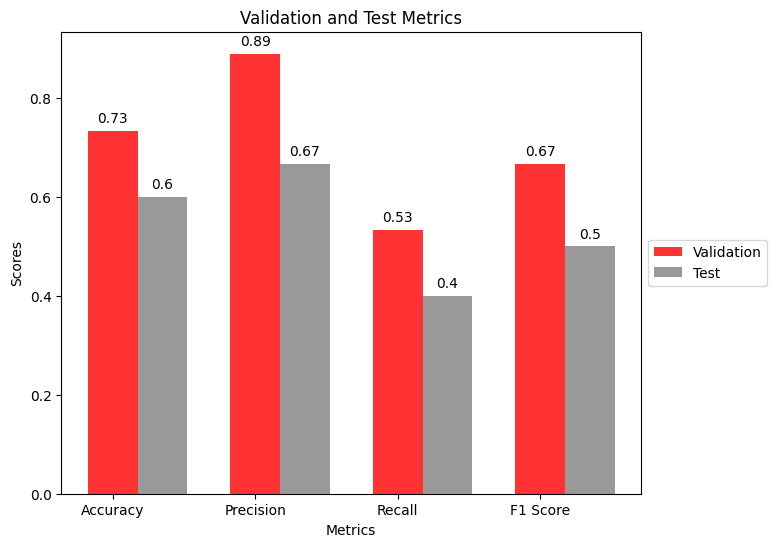

In [22]:
# Validation and Accuracy Bar Chart

# Define the metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Define the values
validation_metrics = [val_accuracy, val_precision, val_recall, val_f1]
test_metrics = [test_accuracy, test_precision, test_recall, test_f1]

# Combine the validation and test metrics for plotting
metrics = np.vstack((validation_metrics, test_metrics))

# Bar chart colours and groups
groups = ['Validation', 'Test']
colors = ['red', 'grey']

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.35
opacity = 0.8

index = np.arange(len(metric_names))

for i in range(len(groups)):
    ax.bar(index + i * bar_width, [validation_metrics[j] if i == 0 else test_metrics[j] for j in range(len(metric_names))], bar_width, alpha=opacity, color=colors[i], label=f'{groups[i]}')

# Data labels
    for j, value in enumerate([validation_metrics[j] if i == 0 else test_metrics[j] for j in range(len(metric_names))]):
        ax.text(index[j] + i * bar_width, value + 0.01, str(round(value, 2)), ha='center', va='bottom')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Validation and Test Metrics')
ax.set_xticks(index)
ax.set_xticklabels(metric_names)
# Add a legend outside of the plot area
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make space for the legend
plt.subplots_adjust(right=0.85)

plt.show()


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        15
           1       0.89      0.53      0.67        15

    accuracy                           0.73        30
   macro avg       0.78      0.73      0.72        30
weighted avg       0.78      0.73      0.72        30

Test Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.80      0.67        15
           1       0.67      0.40      0.50        15

    accuracy                           0.60        30
   macro avg       0.62      0.60      0.58        30
weighted avg       0.62      0.60      0.58        30



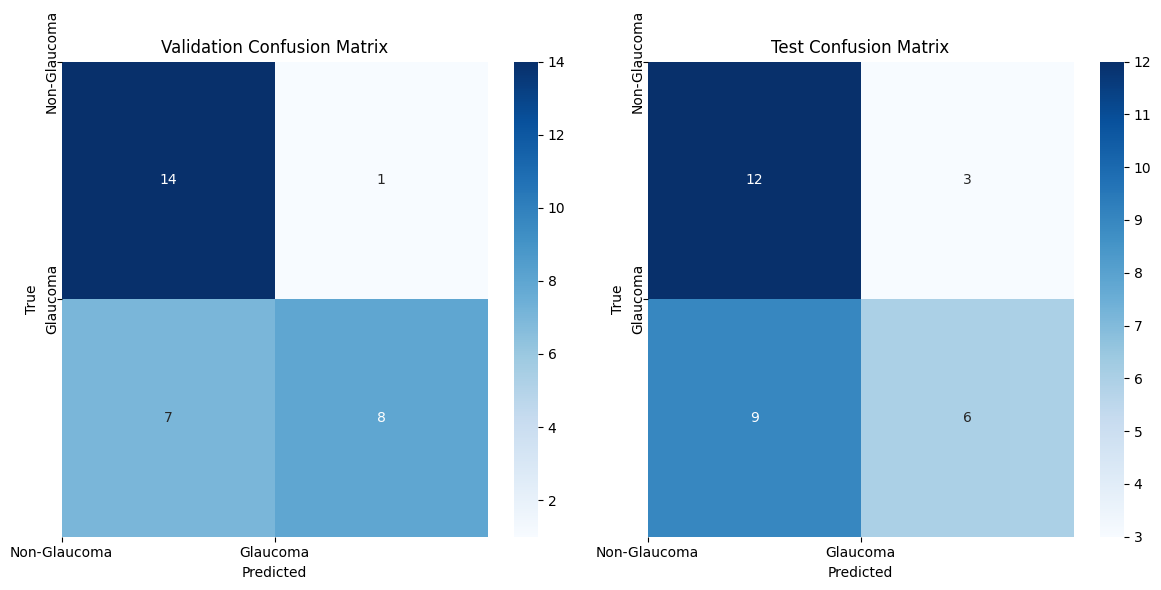

In [23]:
# checking for performance metrices, importing classification_report and confusion metrics
import seaborn as sb

# Classification report for validation set
val_classification_report = classification_report(y_val_true, y_val_pred)
print("Validation Classification Report:")
print(val_classification_report)

# Define class labels
class_labels = ['Non-Glaucoma', 'Glaucoma']

# Confusion matrix for validation set
cm = confusion_matrix(y_val_true, y_val_pred)

# Classification report for test set
test_classification_report = classification_report(y_test_true, y_test_pred)
print("Test Classification Report:")
print(test_classification_report)

# Confusion matrix for test set
cm1 = confusion_matrix(y_test_true, y_test_pred)

# Plot confusion matrix for validation set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sb.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')
plt.xticks(ticks=[0, 1], labels=class_labels, horizontalalignment="center")
plt.yticks(ticks=[0, 1], labels=class_labels, horizontalalignment="center")

# Plot confusion matrix for test set
plt.subplot(1, 2, 2)
sb.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.xticks(ticks=[0, 1], labels=class_labels, horizontalalignment="center")
plt.yticks(ticks=[0, 1], labels=class_labels, horizontalalignment="center")

plt.tight_layout()
plt.show()

1/1 [==============================] - 25s 25s/step


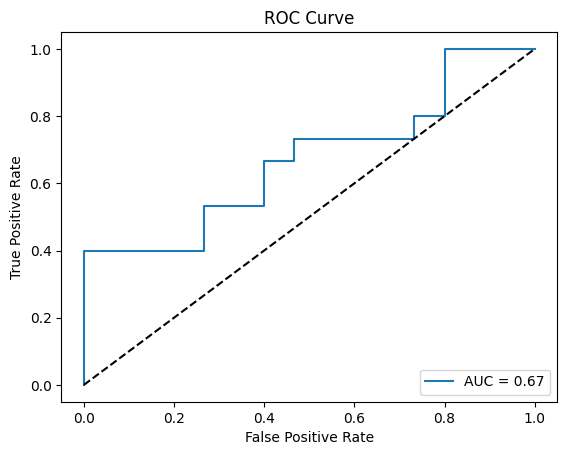

In [24]:
from sklearn.metrics import roc_curve, auc

# Calculate the predicted probabilities for the test set
y_pred_proba = cnn1.predict(test_set_preprocessed)

# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)

# Calculate the AUC (Area Under the Curve)
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [25]:
# Splitting the Fundus Image sets into train, test and validation sets
from sklearn.preprocessing import LabelEncoder

# Fundus images labels
Fundus_normal_images = Fundus_NORM   # List of normal fundus images
Fundus_mild_images = Fundus_MILD   # List of mild severity fundus images
Fundus_moderate_images = Fundus_MOD   # List of moderate severity fundus images
Fundus_severe_images = Fundus_SEV   # List of severe severity fundus images

# Shuffle the images and labels together
random.seed(42)  # Set a seed for reproducibility
random.shuffle(Fundus_normal_images)
random.shuffle(Fundus_mild_images)
random.shuffle(Fundus_moderate_images)
random.shuffle(Fundus_severe_images)

# Define split ratios
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

# Calculate the number of images for each set
num_normal = len(Fundus_normal_images)
num_mild = len(Fundus_mild_images)
num_moderate = len(Fundus_moderate_images)
num_severe = len(Fundus_severe_images)

num_train_normal = int(train_ratio * num_normal)
num_test_normal = int(test_ratio * num_normal)
num_val_normal = num_normal - num_train_normal - num_test_normal

num_train_mild = int(train_ratio * num_mild)
num_test_mild = int(test_ratio * num_mild)
num_val_mild = num_mild - num_train_mild - num_test_mild

num_train_moderate = int(train_ratio * num_moderate)
num_test_moderate = int(test_ratio * num_moderate)
num_val_moderate = num_moderate - num_train_moderate - num_test_moderate

num_train_severe = int(train_ratio * num_severe)
num_test_severe = int(test_ratio * num_severe)
num_val_severe = num_severe - num_train_severe - num_test_severe

# Split normal images into train, test, and validation sets
train_normal = Fundus_normal_images[:num_train_normal]
test_normal = Fundus_normal_images[num_train_normal:num_train_normal+num_test_normal]
val_normal = Fundus_normal_images[num_train_normal+num_test_normal:num_train_normal+num_test_normal+num_val_normal]

# Split mild images into train, test, and validation sets
train_mild = Fundus_mild_images[:num_train_mild]
test_mild = Fundus_mild_images[num_train_mild:num_train_mild+num_test_mild]
val_mild = Fundus_mild_images[num_train_mild+num_test_mild:num_train_mild+num_test_mild+num_val_mild]

# Split moderate images into train, test, and validation sets
train_moderate = Fundus_moderate_images[:num_train_moderate]
test_moderate = Fundus_moderate_images[num_train_moderate:num_train_moderate+num_test_moderate]
val_moderate = Fundus_moderate_images[num_train_moderate+num_test_moderate:num_train_moderate+num_test_moderate+num_val_moderate]

# Split severe images into train, test, and validation sets
train_severe = Fundus_severe_images[:num_train_severe]
test_severe = Fundus_severe_images[num_train_severe:num_train_severe+num_test_severe]
val_severe = Fundus_severe_images[num_train_severe+num_test_severe:num_train_severe+num_test_severe+num_val_severe]

# Combine sets for each split
train_set1 = train_normal + train_mild + train_moderate + train_severe
test_set1 = test_normal + test_mild + test_moderate + test_severe
val_set1 = val_normal + val_mild + val_moderate + val_severe

# Assign labels to each image category
train_labels1 = ['Normal'] * len(train_normal) + ['Mild'] * len(train_mild) + ['Moderate'] * len(train_moderate) + ['Severe'] * len(train_severe)
test_labels1 = ['Normal'] * len(test_normal) + ['Mild'] * len(test_mild) + ['Moderate'] * len(test_moderate) + ['Severe'] * len(test_severe)
val_labels1 = ['Normal'] * len(val_normal) + ['Mild'] * len(val_mild) + ['Moderate'] * len(val_moderate) + ['Severe'] * len(val_severe)

# Define a dictionary to map label names to numerical values
label_mapping = {'Normal': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3}

# Convert the string labels to numerical values
train_labels_numeric = [label_mapping[label] for label in train_labels1]
val_labels_numeric = [label_mapping[label] for label in val_labels1]
test_labels_numeric = [label_mapping[label] for label in test_labels1]

# Verify the lengths of the sets and labels
print(len(train_set1), len(train_labels1))
print(len(test_set1), len(test_labels1))
print(len(val_set1), len(val_labels1))

280 280
60 60
60 60


In [26]:
# Define a dictionary to map label names to numerical values
label_mapping = {'Normal': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3}

# Convert the string labels to numerical values
test_labels_numeric = [label_mapping[label] for label in test_labels1]

# Count the occurrences of each label in the test_labels_numeric array
label_count = np.bincount(test_labels_numeric)

# Print the label distribution
for label, count in zip(label_mapping.keys(), label_count):
    print(f"{label}: {count}")


Normal: 15
Mild: 15
Moderate: 15
Severe: 15


In [27]:
# Create CNN2 architecture for fundus images
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder

# Create CNN2 architecture for fundus images using transfer learning
def create_cnn2(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the convolutional layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)

    model.add(BatchNormalization())

    model.add(Flatten())

    model.add(Dropout(0.6))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.6))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.3))


    model.add(Dense(num_classes, activation='softmax'))

    return model

def load_images(image_paths):
      images = []
      for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to load image: {image_path}")
            continue
          # Convert BGR to RGB format
        images.append(img)
      return np.array(images)

def preprocess_set(images):
    preprocessed_set = []
    for img in images:
        # Preprocess the image (normalize, convert to BGR, etc.)
        preprocessed_img = preprocess_input(img)
        preprocessed_set.append(preprocessed_img)
    return np.array(preprocessed_set)


# Pre-defined train, test, and validation sets
train_set_images1 = load_images(train_set1)
train_set_preprocessed1 = preprocess_set(train_set_images1)

val_set_images1 = load_images(val_set1)
val_set_preprocessed1 = preprocess_set(val_set_images1)

test_set_images1 = load_images(test_set1)
test_set_preprocessed1 = preprocess_set(test_set_images1)

# Convert labels to numpy arrays
train_labels1 = np.array(train_labels1)
val_labels1 = np.array(val_labels1)
test_labels1 = np.array(test_labels1)

# Set the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 4

# Create CNN2 model using transfer learning
cnn2 = create_cnn2(input_shape, num_classes)

# Create the LabelEncoder object
label_encoder = LabelEncoder()

label_mapping = {'Normal': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3}

# Convert the string labels to numerical values
train_labels_numeric = [label_mapping[label] for label in train_labels1]
val_labels_numeric = [label_mapping[label] for label in val_labels1]
test_labels_numeric = [label_mapping[label] for label in test_labels1]

# Convert the numerical labels to one-hot encoding
train_labels_one_hot = keras.utils.to_categorical(train_labels_numeric, num_classes)
val_labels_one_hot = keras.utils.to_categorical(val_labels_numeric, num_classes)
test_labels_one_hot = keras.utils.to_categorical(test_labels_numeric, num_classes)

# Compile the model
cnn2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train CNN2 on your fundus image dataset
cnn2.fit(train_set_preprocessed1, train_labels_one_hot, epochs = 16, batch_size=16, validation_data=(val_set_preprocessed1, val_labels_one_hot))

# Evaluate the model on the validation set
validation_loss, validation_accuracy = cnn2.evaluate(val_set_preprocessed1, val_labels_one_hot, verbose=0)
print(f"Validation accuracy: {validation_accuracy}")

# Evaluate the model on the test set
test_loss, test_accuracy = cnn2.evaluate(test_set_preprocessed1, test_labels_one_hot, verbose=0)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/16
18/18 [==============================] - 220s 12s/step - loss: 31.6252 - accuracy: 0.2857 - val_loss: 31.7789 - val_accuracy: 0.2833
Epoch 2/16
18/18 [==============================] - 215s 12s/step - loss: 24.2861 - accuracy: 0.4429 - val_loss: 22.1904 - val_accuracy: 0.4500
Epoch 3/16
18/18 [==============================] - 217s 12s/step - loss: 19.8410 - accuracy: 0.4964 - val_loss: 18.1734 - val_accuracy: 0.4167
Epoch 4/16
18/18 [==============================] - 215s 12s/step - loss: 16.6651 - accuracy: 0.5679 - val_loss: 15.4489 - val_accuracy: 0.5333
Epoch 5/16
18/18 [==============================] - 213s 12s/step - loss: 14.4340 - accuracy: 0.6179 - val_loss: 13.4953 - val_accuracy: 0.6000
Epoch 6/16
18/18 [==============================] - 218s 12s/step - loss: 12.6040 - accuracy: 0.6500 - val_loss: 11.9518 - val_accuracy: 0.6333
Epoch 7/16
18/18 [==============================] - 216s 12s/step - loss: 11.3440 - accuracy: 0.6429 - val_loss: 10.7476 - val_accuracy:

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_4 (Dropout)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                      

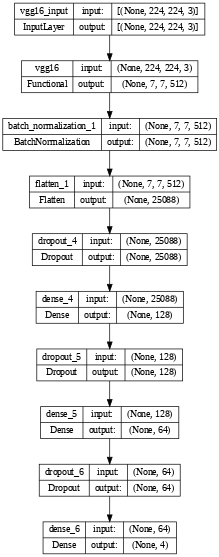

In [28]:
# Architecture for CNN2

# Print the model summary
cnn2.summary()
# Save the model architecture diagram to a file
plot_model(cnn2, to_file='model_architecture.png', show_shapes=True, dpi=50)

Epoch 1/16
18/18 [==============================] - 215s 12s/step - loss: 5.5117 - accuracy: 0.8929 - val_loss: 5.6787 - val_accuracy: 0.7167
Epoch 2/16
18/18 [==============================] - 213s 12s/step - loss: 5.0555 - accuracy: 0.9036 - val_loss: 5.2934 - val_accuracy: 0.6833
Epoch 3/16
18/18 [==============================] - 216s 12s/step - loss: 4.6405 - accuracy: 0.9286 - val_loss: 4.9733 - val_accuracy: 0.6500
Epoch 4/16
18/18 [==============================] - 217s 12s/step - loss: 4.2822 - accuracy: 0.9179 - val_loss: 4.7056 - val_accuracy: 0.6167
Epoch 5/16
18/18 [==============================] - 219s 12s/step - loss: 4.0923 - accuracy: 0.9214 - val_loss: 4.6659 - val_accuracy: 0.5833
Epoch 6/16
18/18 [==============================] - 216s 12s/step - loss: 4.0707 - accuracy: 0.9071 - val_loss: 4.6551 - val_accuracy: 0.6333
Epoch 7/16
18/18 [==============================] - 220s 12s/step - loss: 4.0125 - accuracy: 0.8893 - val_loss: 4.6872 - val_accuracy: 0.6667
Epoch 

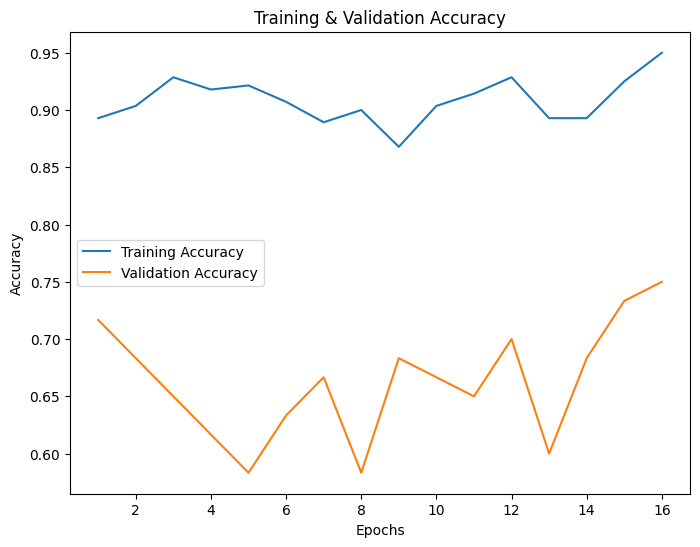

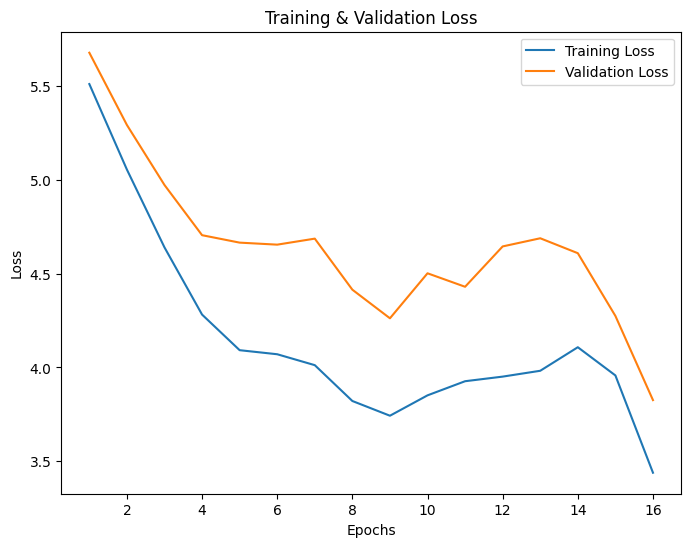

In [29]:
# Creating plots for model accuracy and model loss
# Access the training history
history = cnn2.fit(train_set_preprocessed1, train_labels_one_hot, epochs=16, batch_size=16, validation_data=(val_set_preprocessed1, val_labels_one_hot))

# Extract the training loss and accuracy values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a range of epochs based on the length of the training history
epochs = range(1, len(train_loss) + 1)

# Create a figure for model accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

# Create a figure for model loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

In [30]:
# Metrics for CNN2

# Obtain predicted probabilities for validation and test sets
val_probabilities1 = cnn2.predict(val_set_preprocessed1)
test_probabilities1 = cnn2.predict(test_set_preprocessed1)

# Convert probabilities to binary labels
y_val_pred1 = np.argmax(val_probabilities1, axis=1)
y_test_pred1 = np.argmax(test_probabilities1, axis=1)

# Convert the one-hot encoded labels back to integers
y_val_true1 = np.argmax(val_labels_one_hot, axis=1)
y_test_true1 = np.argmax(test_labels_one_hot, axis=1)

# Calculate the validation metrics
val_accuracy1 = accuracy_score(y_val_true1, y_val_pred1)
val_precision1 = precision_score(y_val_true1, y_val_pred1, average='macro')
val_recall1 = recall_score(y_val_true1, y_val_pred1, average = 'macro')
val_f11 = f1_score(y_val_true1, y_val_pred1, average = 'macro')

# Calculate the test metrics
test_accuracy1 = accuracy_score(y_test_true1, y_test_pred1)
test_precision1 = precision_score(y_test_true1, y_test_pred1 , average = 'macro')
test_recall1 = recall_score(y_test_true1, y_test_pred1, average = 'macro')
test_f11 = f1_score(y_test_true1, y_test_pred1, average = 'macro')

print("Accuracy:", val_accuracy1)
print("Validation Precision:", val_precision1)
print("Validation Recall:", val_recall1)
print("Validation F1 Score:", val_f11)

print("Test Accuracy:", test_accuracy1)
print("Test Precision:", test_precision1)
print("Test Recall:", test_recall1)
print("Test F1 Score:", test_f11)


2/2 [==============================] - 37s 17s/step
Accuracy: 0.75
Validation Precision: 0.7641898864809081
Validation Recall: 0.75
Validation F1 Score: 0.7490468409586057
Test Accuracy: 0.7666666666666667
Test Precision: 0.7870535714285715
Test Recall: 0.7666666666666667
Test F1 Score: 0.7650468774829176


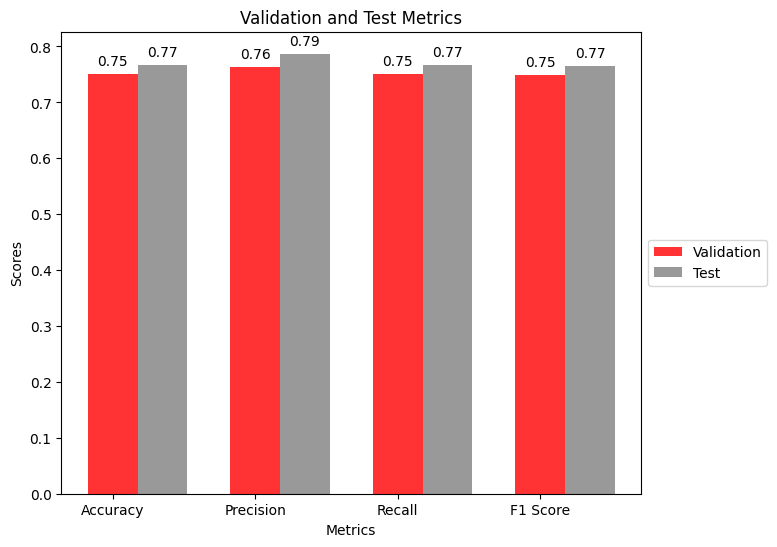

In [31]:
# Plot of Validation and Accuracy

# Define the metrics
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Define the values
validation_metrics1 = [val_accuracy1, val_precision1, val_recall1, val_f11]
test_metrics1 = [test_accuracy1, test_precision1, test_recall1, test_f11]

# Combine the validation and test metrics for plotting
metrics1 = np.vstack((validation_metrics1, test_metrics1))

# Bar chart colour and groups
groups = ['Validation', 'Test']
colors = ['red', 'grey']

# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.35
opacity = 0.8

index = np.arange(len(metric_names))

for i in range(len(groups)):
    ax.bar(index + i * bar_width, [validation_metrics1[j] if i == 0 else test_metrics1[j] for j in range(len(metric_names))], bar_width, alpha=opacity, color=colors[i], label=groups[i])

# Data labels
for i in range(len(groups)):
    for j, value in enumerate([validation_metrics1[j] if i == 0 else test_metrics1[j] for j in range(len(metric_names))]):
        ax.text(index[j] + i * bar_width, value + 0.01, str(round(value, 2)), ha='center', va='bottom')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Validation and Test Metrics')
ax.set_xticks(index)
ax.set_xticklabels(metric_names)

# Add a legend outside of the plot area
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout to make space for the legend
plt.subplots_adjust(right=0.85)
plt.show()

              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.71      0.80      0.75        15
           2       0.68      0.87      0.76        15
           3       0.92      0.73      0.81        15

    accuracy                           0.75        60
   macro avg       0.76      0.75      0.75        60
weighted avg       0.76      0.75      0.75        60



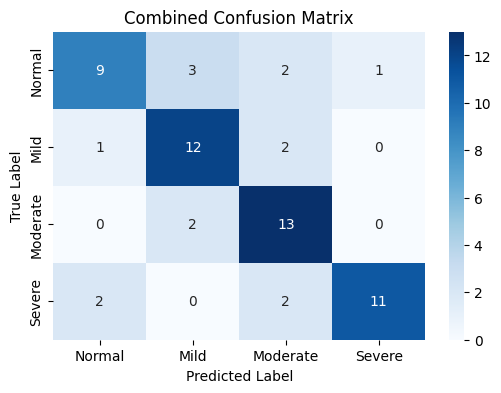

In [32]:
# Classification_report and confusion matrix for CNN2

# Classification_report
classification_report1 = classification_report(y_val_true1, y_val_pred1)
print (classification_report1)

# Create the confusion matrix
confusion_matrix1 = confusion_matrix(y_val_true1, y_val_pred1)

# Class labels
classes = ['Normal', 'Mild', 'Moderate', 'Severe']

# Plot the combined confusion matrix
plt.figure(figsize=(6, 4))
sb.heatmap(confusion_matrix1, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Combined Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


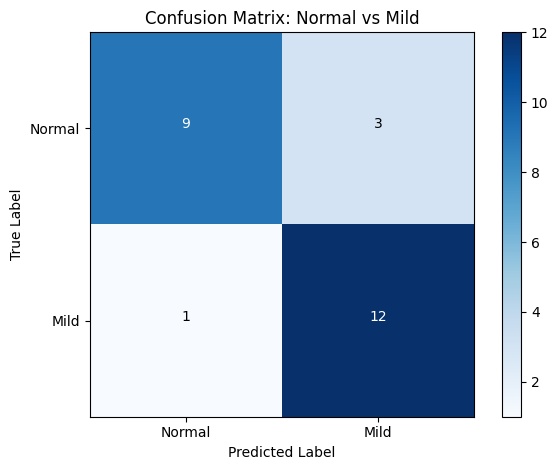

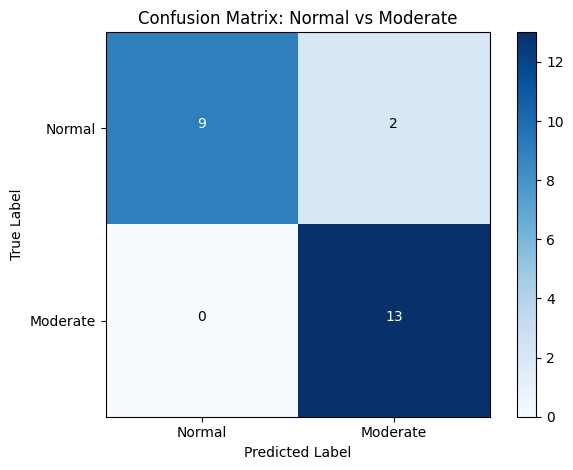

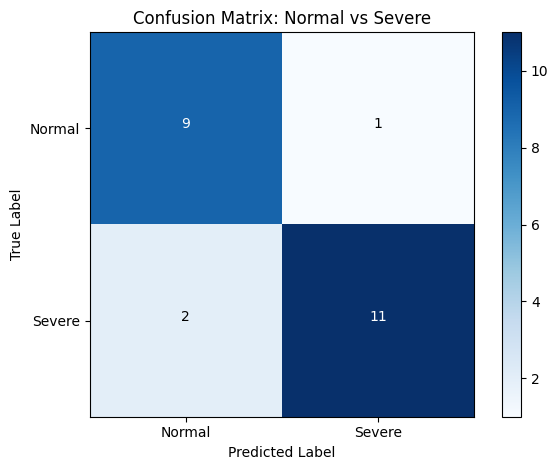

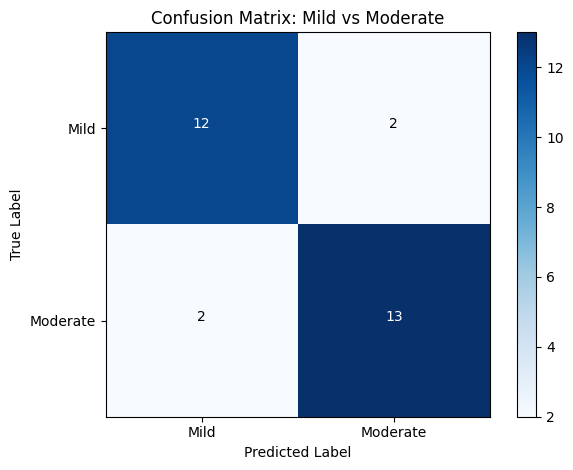

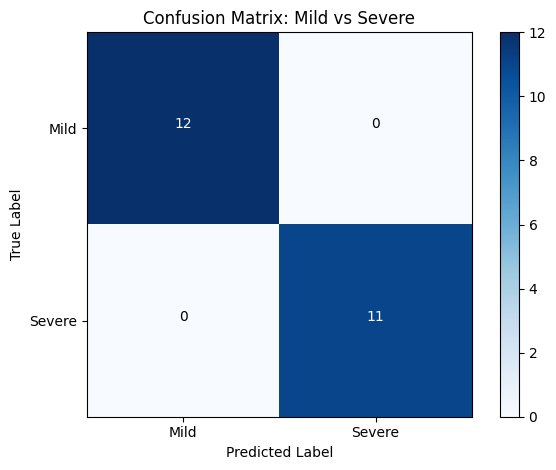

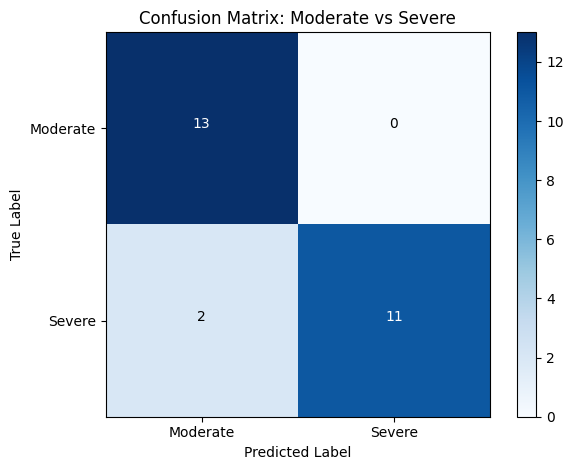

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sb
from sklearn.metrics import confusion_matrix


# Create the confusion matrix
confusion_matrix2 = confusion_matrix(y_val_true1, y_val_pred1)

# Class labels
classes = ['Normal', 'Mild', 'Moderate', 'Severe']

# Create separate charts for each class combination
for i in range(len(classes)):
    for j in range(i+1, len(classes)):  # Iterate from i+1 to avoid duplicates
        # Create a new figure for each class combination
        plt.figure()

        # Extract the corresponding values from the confusion matrix
        cm_subset = confusion_matrix1[[i, j]][:, [i, j]]

        # Plot the confusion matrix subset
        plt.imshow(cm_subset, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix: {classes[i]} vs {classes[j]}')
        plt.colorbar()
        plt.xticks([0, 1], [classes[i], classes[j]])
        plt.yticks([0, 1], [classes[i], classes[j]])

        # Plot labels
        thresh = cm_subset.max() / 2.
        for x, y in itertools.product(range(cm_subset.shape[0]), range(cm_subset.shape[1])):
            plt.text(y, x, format(cm_subset[x, y], 'd'), horizontalalignment="center",
                     color="white" if cm_subset[x, y] > thresh else "black")

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

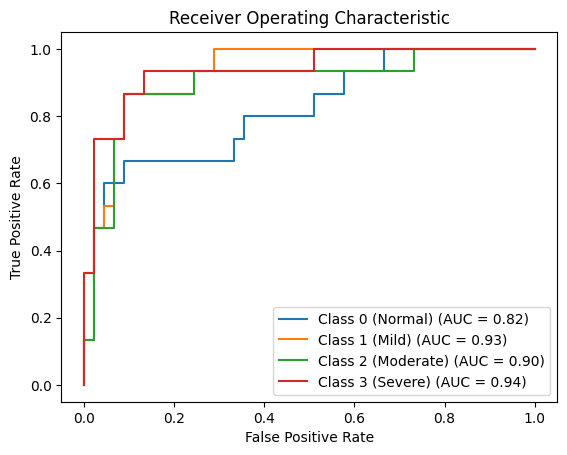

AUC (Class 0 - Normal): 0.82
AUC (Class 1 - Mild): 0.93
AUC (Class 2 - Moderate): 0.90
AUC (Class 3 - Severe): 0.94


In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Number of classes
num_classes = len(np.unique(y_val_true1))

# Class mappings
label_mapping = {'Normal': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3}

# Reverse the label mapping to get class names from indices
class_names = {v: k for k, v in label_mapping.items()}

# Initialize empty lists to store FPR, TPR, and AUC values for each class
fpr_list = []
tpr_list = []
auc_list = []

# Compute FPR, TPR, and AUC for each class
for class_index in range(num_classes):
    # Binarize the true labels for the current class
    y_true_binary = np.where(y_val_true1 == class_index, 1, 0)

    # Compute the predicted probabilities for the current class
    y_pred_proba = val_probabilities1[:, class_index]

    # Compute FPR, TPR, and threshold values for the current class
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_proba)

    # Compute the AUC for the current class
    roc_auc = auc(fpr, tpr)

    # Append the FPR, TPR, and AUC values to the respective lists
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)

    # Plot the ROC curve for the current class
    plt.plot(fpr, tpr, label='Class {0} ({1}) (AUC = {2:.2f})'.format(class_index, class_names[class_index], roc_auc))

# Plot the ROC curve for all classes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

# Print the AUC values for each class
for class_index, auc_value in enumerate(auc_list):
    class_name = class_names[class_index]
    print("AUC (Class {0} - {1}): {2:.2f}".format(class_index, class_name, auc_value))
